## QRS Complex Detection using Pan-Tompkins Algorithm
<a name='0'></a>

* [1. Loading Dataset](#1)
* [2. Band Pass Filter](#2)
* [3. High Pass Filter](#3)
* [4. Derivative](#4)
* [5. Squarring](#5)
* [6. Moving Average Window](#6)
* [7. Thresholding](#7)
* [8. Find The QRS Complex points](#8)
* [9. Feature Extrction](#9)

In [49]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.signal import find_peaks

<a name='1'></a>
## 1. Loading Dataset

In this project we use The MIT-BIH Malignant Ventricular Arrhythmia Database from [physionet.com](https://archive.physionet.org/physiobank/database/vfdb/). 

This database includes 22 half-hour ECG recordings of subjects who experienced episodes of sustained ventricular tachycardia, ventricular flutter, and ventricular fibrillation. 

In [50]:
# loading the Dataset
dataset = pd.read_csv("./ECG.csv")
x = dataset.loc[ : , "ECG1"]

Now that we have the dataset, we can try to see what it looks like.
Here fs is sampling frequency and N is the approximate width of expected QRS

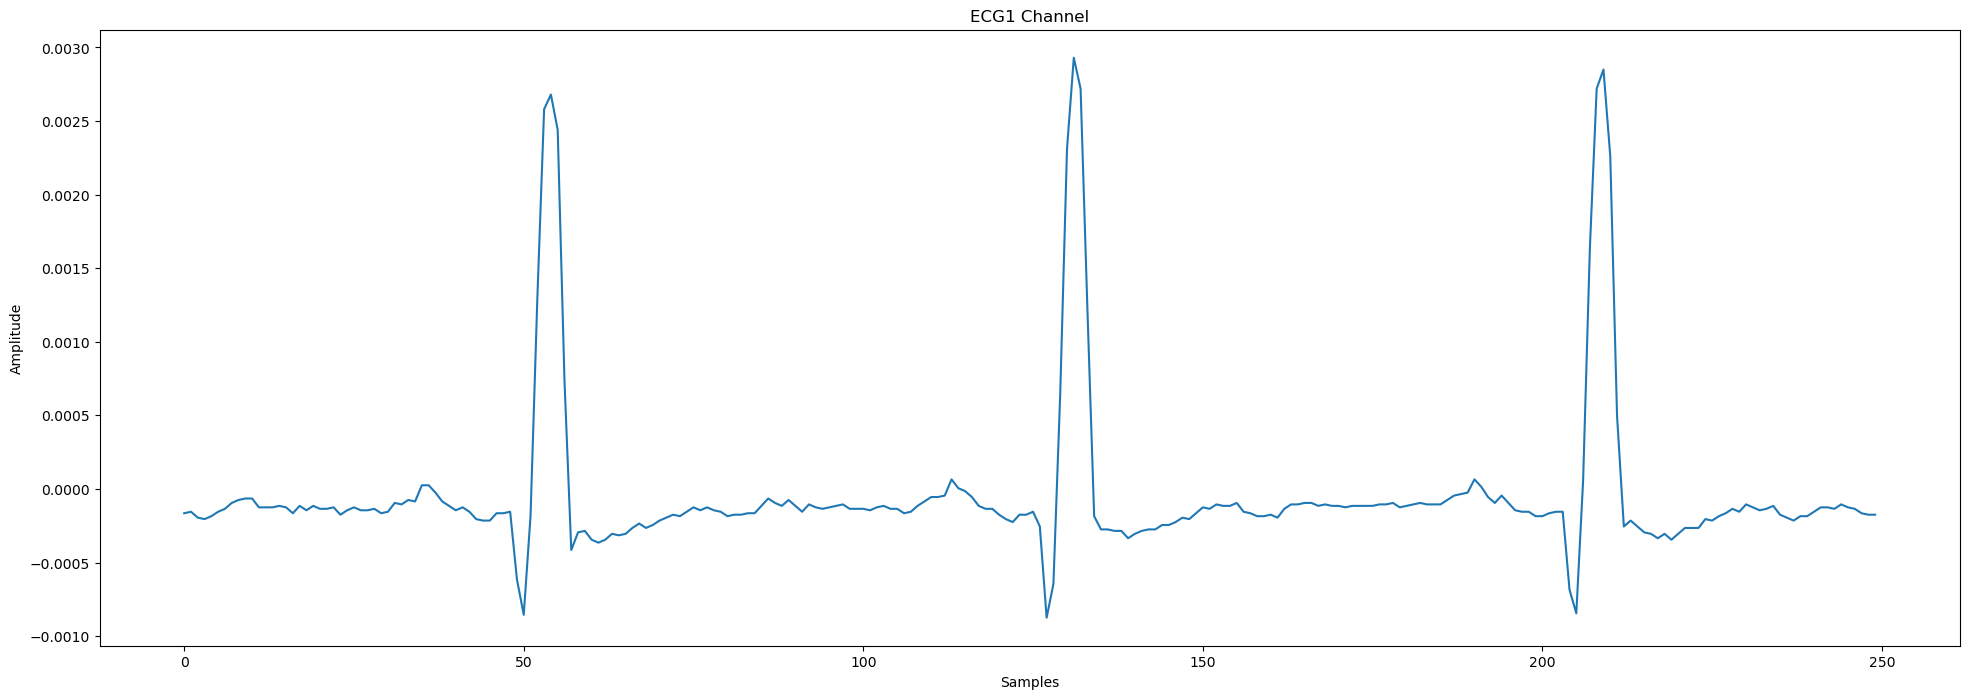

In [52]:
fs = 128
N = 24

# Visualization
plt.figure(figsize=(24, 8))
plt.plot(x[:250])
plt.title('ECG1 Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.savefig("Input Signal", format="png")
plt.show()

In [22]:
print("Average value of signal:", np.average(x))

Average value of signal: -4.6056533867391444e-05


<a name='2'></a>
## 2. Band Pass Filter:
First, high frequency components are removed by a low pass filter. Transfer function is given by H(z) = $ \frac{(1-z^{-6})^{2}} {(1-z^{-1})^{2}} \\ $


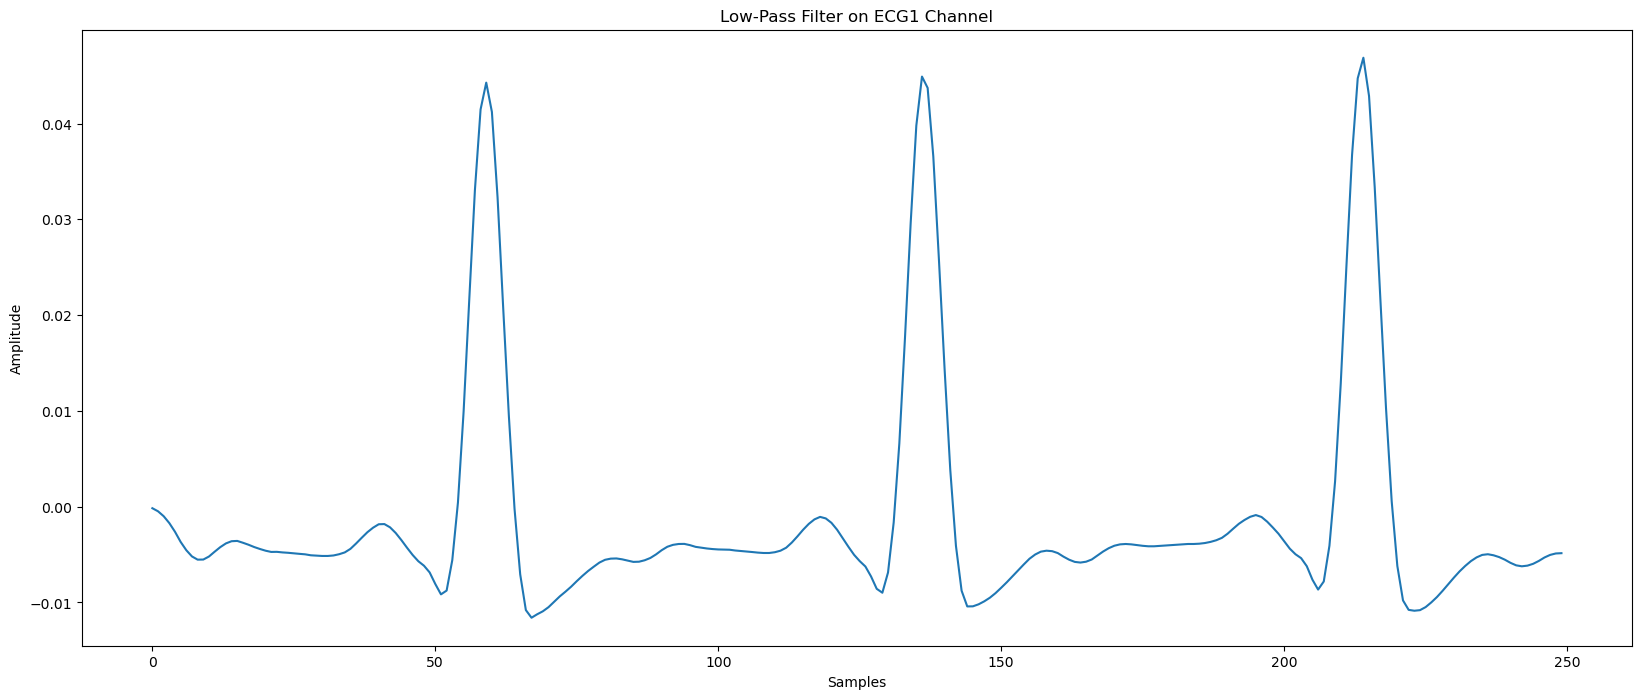

In [57]:
#Low-Pass Filter
x1 = sig.lfilter([1,0,0,0,0,0,-2,0,0,0,0,0,1], [1,-2,1], x)
plt.figure(figsize=(20, 8))
plt.plot(x1[:250])
plt.title('Low-Pass Filter on ECG1 Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.savefig("Low-Pass Filter", format="png")
plt.show()

High pass filter with a transfer function H(z) = $ \frac{(-1-32z^{-16}+z^{-32})} {(1-z^{-1})} \\ $

<a name='3'></a>
## 3. High-Pass Filter

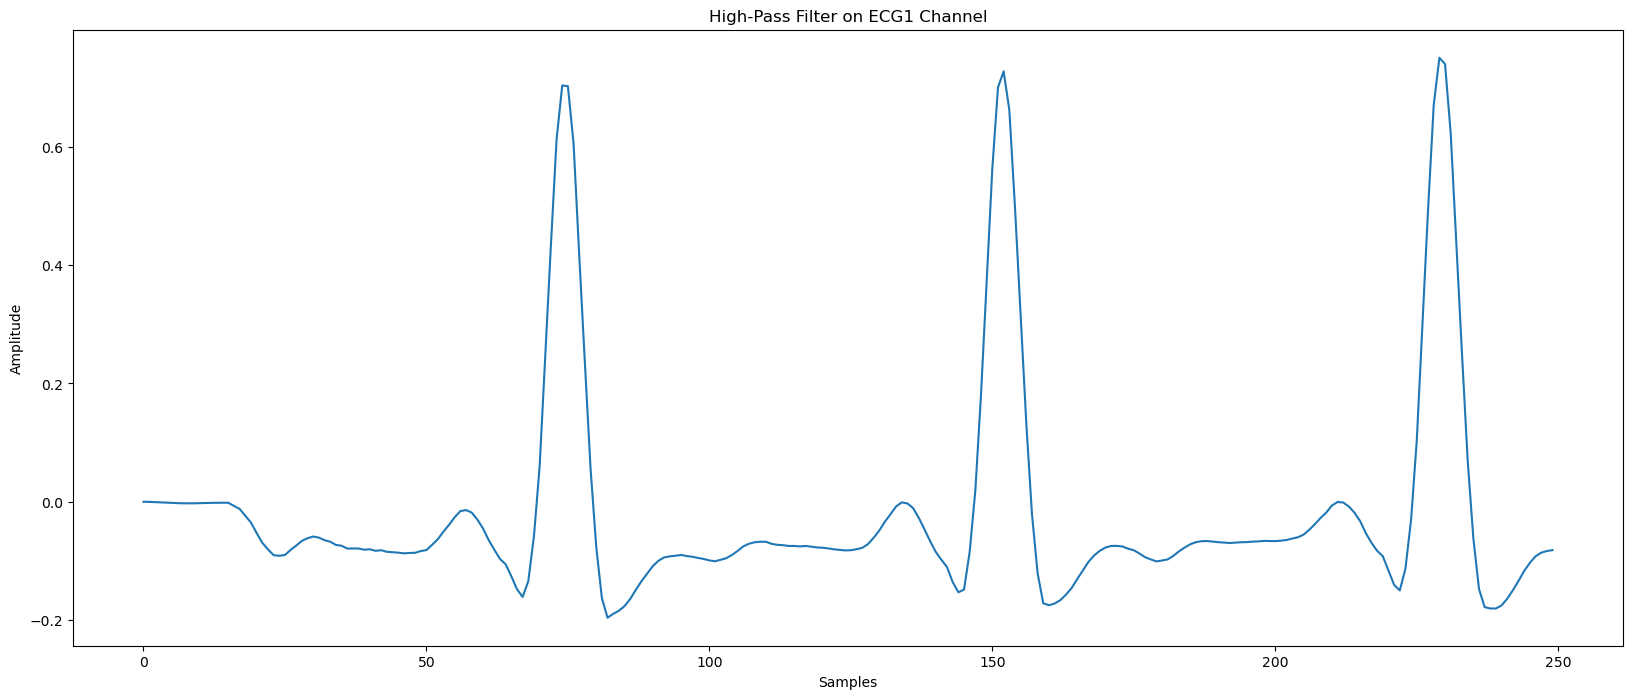

1048575


In [58]:
#High-Pass Filter
x2 = sig.lfilter([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1], [1,1], x1)
plt.figure(figsize=(20, 8))
plt.plot(x2[: 250])
plt.title('High-Pass Filter on ECG1 Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.savefig("High-Pass Filter", format="png")
plt.show()
print(len(x2))

<a name='4'></a>
## 4. Derivative:
The signal x2 is differentiatied in discrete time based on the transfer function $ H(z) = \frac{(-z^{-2}-2z^{-1}+2z^{1}+z^{2})}{8fs} $

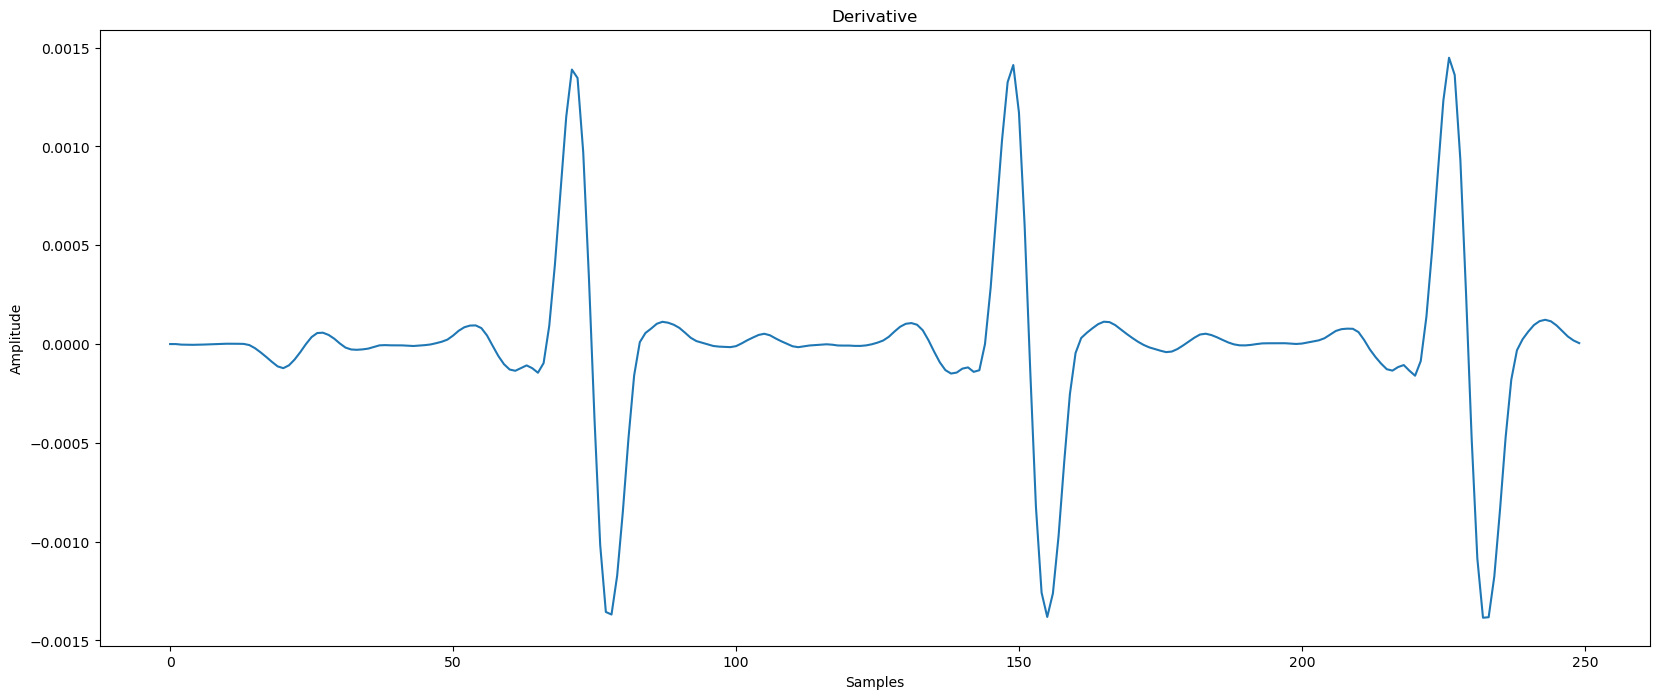

In [59]:
x3 = np.zeros(x.shape)
for i in range(2, len(x2) - 2):
    x3[i] = (-1*x2[i-2] -2*x2[i-1] + 2*x2[i+1] + x2[i+2])/(8*fs)
plt.figure(figsize=(20, 8))
plt.title("Derivative")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(x3[:250])
plt.savefig("Derivative", format="png")
plt.show()

<a name='5'></a>
## 5. Squaring:
this part of code squares each term as $y[nt] = x[nt]^{2} $ and returns signal $ x_4 $

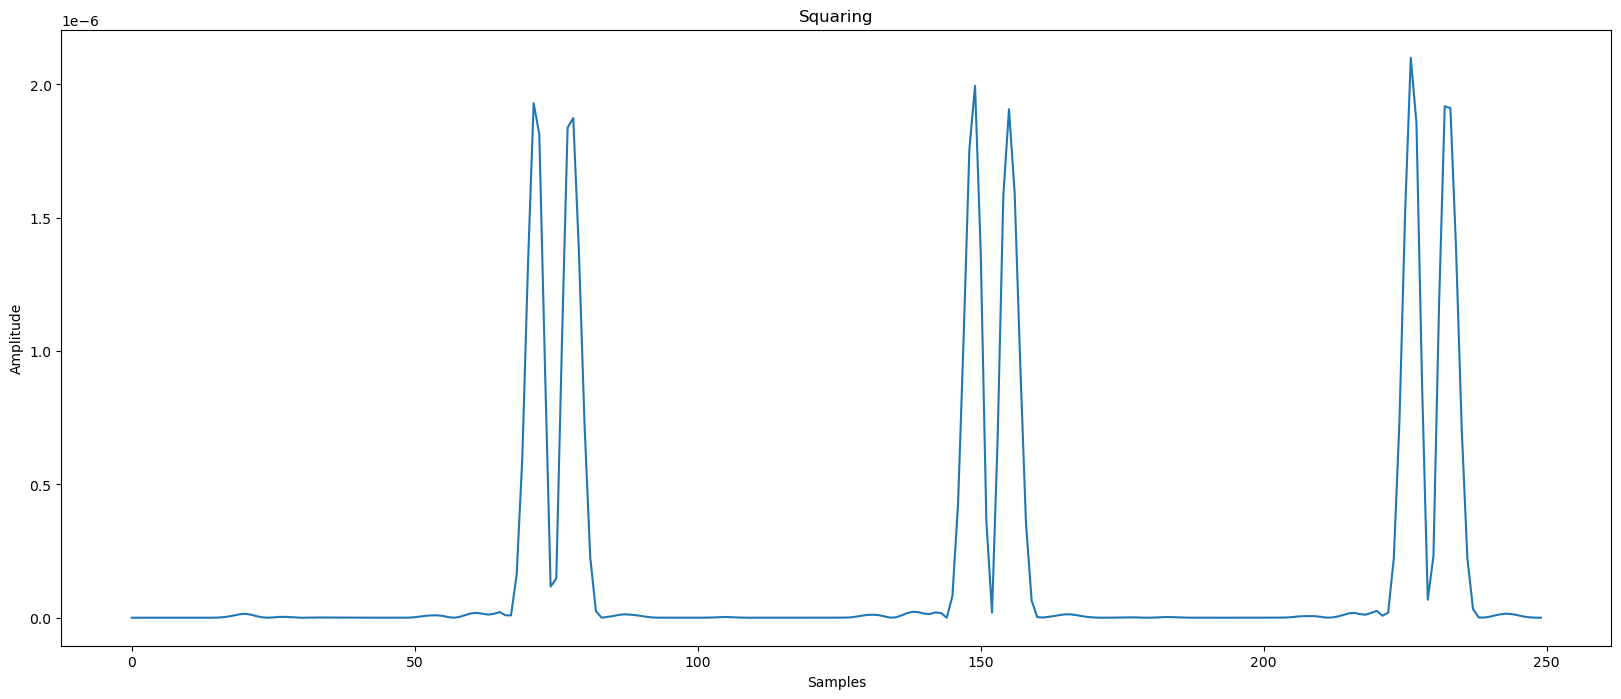

In [60]:
x4 = x3*x3

plt.figure(figsize=(20, 8))
plt.title("Squaring")
plt.plot(x4[:250])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.savefig("Squaring", format="png")
plt.show()
#print(av,std)

<a name='6'></a>
## 6. Moving Window Average:
A moving window average is taken with window size N as defined previously.
$ y[nt] = \frac {\sum_{k=0}^{(N-1)} x[nT - kT]} {N} $

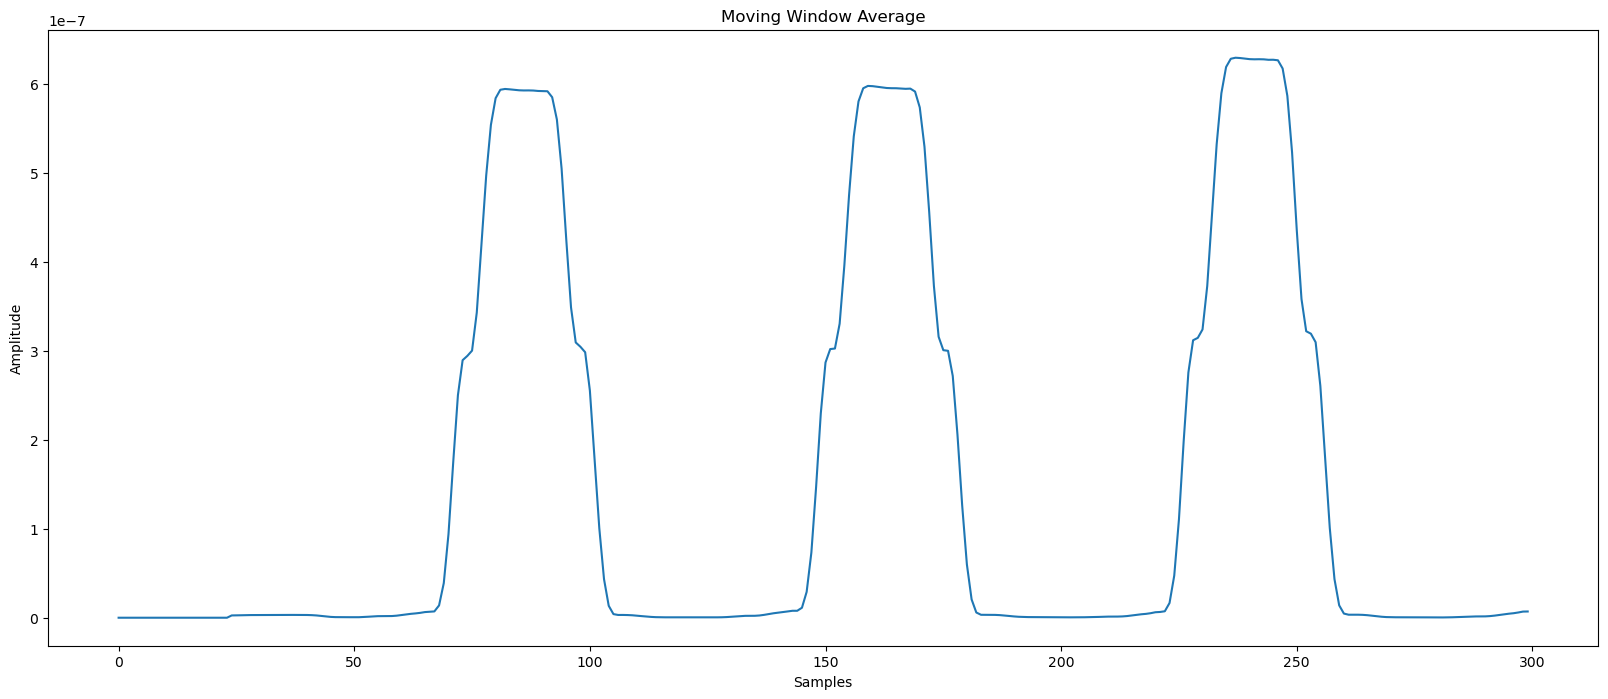

In [61]:
x5 = np.zeros(x.shape)
# print(x5)
for i in range(N, len(x4)-N):
    for j in range(N):
        x5[i] += x4[ i - j ]
x5 = x5/N
plt.figure(figsize=(20, 8))
plt.title("Moving Window Average")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(x5[:300])
plt.savefig("Moving Window Average", format="png")
plt.show()

<a name='7'></a>
## 7. Thresholding
### Noise Signal:
We will consider the noise to be the part that was removed after bandpass filter. For this we define noise as $x_n = \frac {x - x_2}{32*36}$ where 32 and 36 are gains of the filters applied.


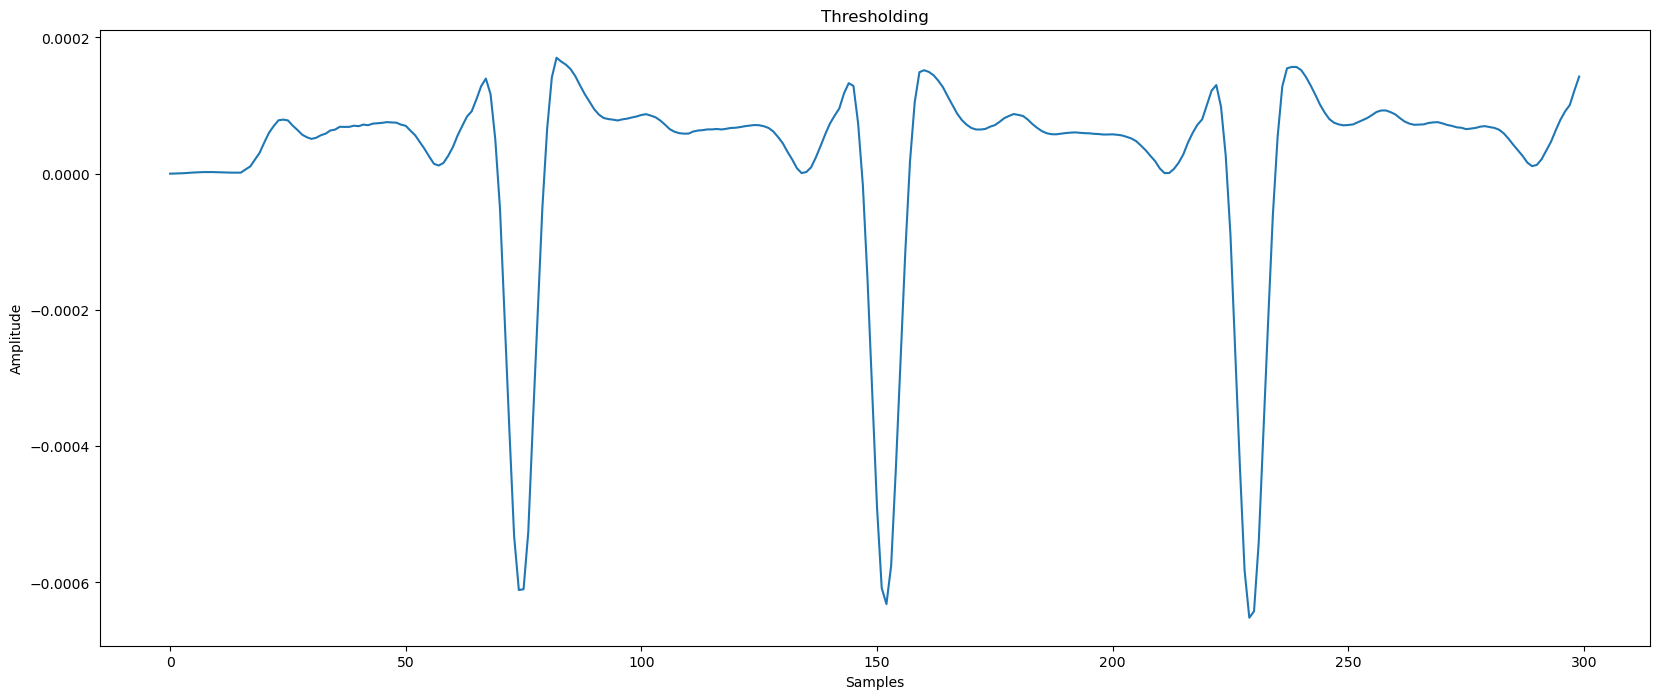

In [62]:
# Noise
xn = (x - x2)/(36*32)

plt.figure(figsize=(20, 8))
plt.plot(xn[:300])
plt.title("Thresholding")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.savefig("Tresholding", format="png")
plt.show()


### Peaks and Averages:
The variable $peaki$ shows the max value of the signal $x_5$ and
$spki$ shows the average of the signal $x_5$ <br>

### Updation:
After each iteration, the value of $spki = 0.125*peaki + 0.875*spki$ <br>
and the value of $npki = 0.125*peaki + 0.875*npki$
### Initial Thresholding:
Threshold values are based on the formula $NPKI + 0.25(SPKI - NPKI)$ and the other threshold will be half of first
Peaks can be detected.

In [34]:
peaki = x5[0] # max value of the signal  𝑥5
spki = 0
npki = 0
peak = [0]
threshold1 = spki
for i in range(1, len(x5)):
    if x5[i]>peaki:
        peaki = x5[i]
                     
    npki = ((npki*(i-1))+xn[i])/i
    spki = ((spki*(i-1))+x5[i])/i
    spki = 0.875*spki + 0.125*peaki
    npki = 0.875*npki + 0.125*peaki
    
    threshold1 = npki + 0.25*(spki-npki)
    threshold2 = 0.5 * threshold1

    if(x5[i]>=threshold2):
        if(peak[-1]+N<i):
            peak.append(i)
            
print("Threshold 1: ", threshold1)
print("Threshold 2: ", threshold2)
print("Number of Peaks: ", len(peak))

Threshold 1:  2.282133729409941e-06
Threshold 2:  1.1410668647049705e-06
Number of Peaks:  3449


### Final Thresholding:
This is learning phase II where remaining signals can be identified and counted.

In [35]:
peak2 = np.array(peak)
avg = np.average(np.diff(peak))
thresholdf1 = 0
thresholdf2 = 0
peakf = x5[0]
spkf = 0
npkf = 0
for i in range(1, len(peak)):
    peakf = x5[i-1]
    spkf = 0
    npkf = 0
    if(peak[i]-peak[i-1]>=1.66*avg): 
        for j in range(int(peak[i-1])+1, int(peak[i])):
            if x5[j]>peakf:
                peakf = x5[j]
            npkf = ((npkf*(j-1))+xn[j])/j
            spkf = ((spkf*(j-1))+x5[j])/j
            spkf = 0.875*spkf + 0.125*peakf
            npkf = 0.875*npkf + 0.125*peakf
            
            thresholdf1 = (npkf + 0.25*(spkf-npkf))
            thresholdf2 = 0.5 * thresholdf1

            if(x5[j]>=thresholdf2):
                if(peak2[-1]< j):
                    peak.append(j)

print("Threshold 1: ", thresholdf1)
print("Threshold 2: ", thresholdf2)
print("Number of Peaks: ", len(peak))

Threshold 1:  1.926974047459274e-06
Threshold 2:  9.63487023729637e-07
Number of Peaks:  3449


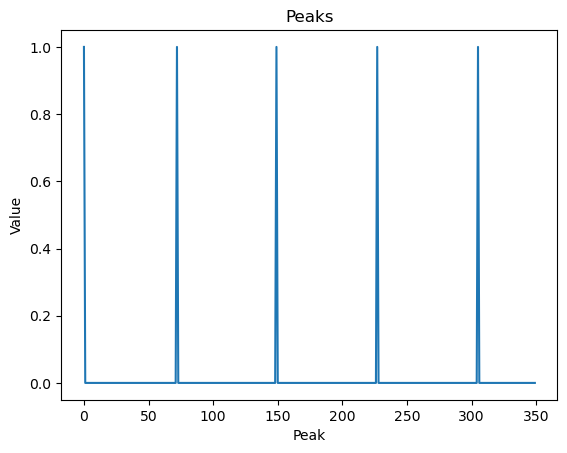

In [69]:
# Peaks
p = np.zeros(len(x5))
for i in peak:
    p[i]=1
plt.plot(p[:350])
plt.title('Peaks')
plt.xlabel('Peak')
plt.ylabel('Value')
plt.show()
# print("R Peaks: ", peak)
# len(peak)
# p.shape

<a name='8'></a>
## 8. Find The QRS Complex points

We will find The QRS complex points 

ValueError: attempt to get argmax of an empty sequence

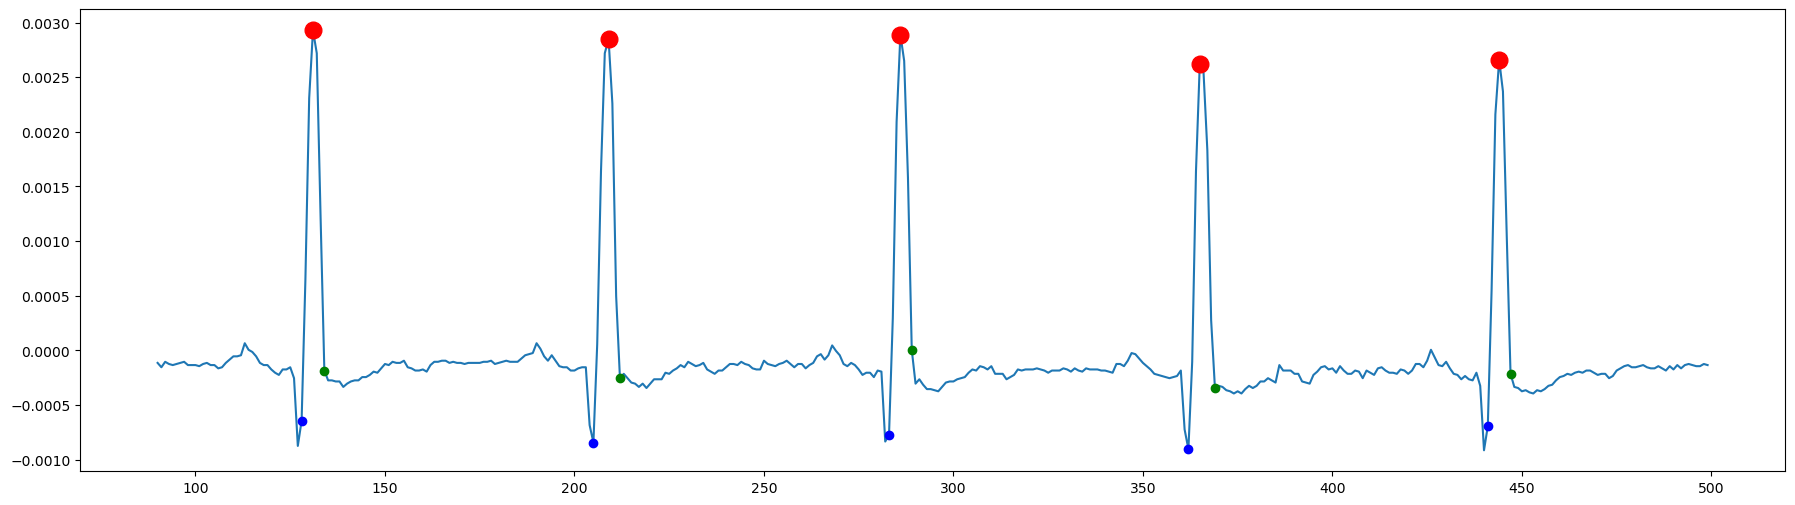

In [63]:
p = np.zeros(len(x5))
rPeak = []
s = []
q = []
Q = np.zeros(2)
S = np.zeros(2)
Ramps = []
Qamps = []
Samps = []
QRSds = []

rE = fs//3   # 42
E = fs//7    # 18
THR = 5

plt.figure(figsize=(22, 6))
plt.plot(x[90:500])

# R Peaks
for i in peak:
    if(i==0 or i<2*rE):
        continue
    p[i]=1
    ind = np.argmax(x[:500][i - rE : i + rE])
    maxIndexR = (ind + i - rE)
    rPeak.append(maxIndexR)
    Ramps.append(x[maxIndexR])
    plt.plot(maxIndexR, x[maxIndexR], 'ro', markersize=12)
    prevDiffQ = 0
    prevDiffS = 0

    # Q Points  Features
    for i in range(1,THR):

        Q[0] = x[maxIndexR - i]
        Q[1] = x[maxIndexR - (i + 1)]

        diffQ = Q[0]-Q[1]

        if(diffQ<prevDiffQ):
            minIndexQ = maxIndexR-i
            q.append(minIndexQ)
            Qamps.append(x[minIndexQ])
            break
            
        prevDiffQ = diffQ / 5
    plt.plot(minIndexQ, x[minIndexQ],'bo', markersize=6)   
        
    
    
    # S Points
    for i in range(1,THR):

        S[0] = x[maxIndexR + i]
        S[1] = x[maxIndexR + ( i+1)]

        diffS = S[0]-S[1]

        if(diffS<prevDiffS):
            minIndexS = maxIndexR+i
            s.append(minIndexS)
            Samps.append(x[minIndexS])
            break
        prevDiffS = diffS / 5
    plt.plot(minIndexS,x[minIndexS],'go', markersize=6)
    
    #QRS duration
    for i in range( len(s)):
        qrsd = s[i] - q[i]
        QRSds.append(qrsd)

<a name='9'></a>
## 9. Feature Extraction

Extracting morphological features and time domain features from filtered Signal 

In [66]:

# rPeak = np.unique(rPeak)
# print(rPeak)
# d = x[0][maxIndexR]
# print("DDDD: ", d)

mQRSd = 0.008 * np.mean(QRSds)
sdQRSd = 0.008 * np.std(QRSds)
mRamp = np.mean(Ramps)
sdRamp = np.std(Ramps)
mQamp = np.mean(Qamps)
sdQamp = np.std(Qamps)
mSamp = np.mean(Samps)
sdSamp = np.std(Samps)


print("Extracted Features.")
print('-----------------------------------------------------')
hb = np.average(np.diff(peak))/ fs
HR = 60 / hb
print("Heart rate in Beats Per Minutes: ",HR)
print('-----------------------------------------------------')
mRR = (1 / len(peak)) * sum(RRi)
# mRR = (1 / len(peak)) * sum(np.diff(peak))
print("Mean of all RR intervals: ", mRR)
print('-----------------------------------------------------')
RMSSD = np.sqrt((1 / len(peak)) * sum(np.diff(RRi)) ** 2)
print("RMSSD: ", RMSSD)
print('-----------------------------------------------------')
SDNN = np.sqrt((1 / len(peak)) * sum((RRi - mRR) ** 2))
print("SDNN: ", SDNN)
# print('-----------------------------------------------------')
# print("QRS Durations: ", QRSds)
# print("R Peaks: ", rPeak)
# print("Q Points: ", q)
# print("S Points: ", s)
print('-----------------------------------------------------')
print("Mean mQRSd: ", mQRSd)
print("STD mQRSd: ", sdQRSd)
print('-----------------------------------------------------')
# print("R Amplitudes: ", Ramps)
print('Mean Ramps: ' , mRamp)
print('STD Ramps: ' , sdRamp)
print('-----------------------------------------------------')
# print("Q Amplitudes: ", Qamps)
print('Mean Qamps: ' , mQamp)
print('STD Qamps: ' , sdQamp)
print('-----------------------------------------------------')
# print("S Amplitudes: ", Samps)
print('Mean Samps: ' , mSamp)
print('STD Samps: ' , sdSamp)
print('-----------------------------------------------------')


FeaturesDf = pd.DataFrame()
FeaturesDf ['HR'] = [HR]
FeaturesDf ['mRR'] = [mRR]
FeaturesDf ['RMSSD'] = [RMSSD]
FeaturesDf ['SDNN'] = [SDNN]
FeaturesDf ['mQRSd'] = [mQRSd]
FeaturesDf ['sdQRSd'] = [sdQRSd]
FeaturesDf ['mQamp'] = [mQamp]
FeaturesDf ['sdQamp'] = [sdQamp]
FeaturesDf ['mSamp'] = [mSamp]
FeaturesDf ['sdSamp'] = [sdSamp]
FeaturesDf ['mRamp'] = [mRamp]
FeaturesDf ['sdRamp'] = [sdRamp]

FeaturesDf

Extracted Features.
-----------------------------------------------------
Heart rate in Beats Per Minutes:  33.10609697551608
-----------------------------------------------------
Mean of all RR intervals:  0.1855313424180928
-----------------------------------------------------
RMSSD:  5.209123818302842
-----------------------------------------------------
SDNN:  5.418526054101286
-----------------------------------------------------
Mean mQRSd:  0.0512
STD mQRSd:  0.0039191835884530846
-----------------------------------------------------
Mean Ramps:  0.00279
STD Ramps:  0.00012569805089976537
-----------------------------------------------------
Mean Qamps:  -0.000773
STD Qamps:  9.495261976375378e-05
-----------------------------------------------------
Mean Samps:  -0.000199
STD Samps:  0.00011534296684236972
-----------------------------------------------------


,HR,mRR,RMSSD,SDNN,mQRSd,sdQRSd,mQamp,sdQamp,mSamp,sdSamp,mRamp,sdRamp
0,33.106097,0.185531,5.209124,5.418526,0.0512,0.003919,-0.000773,0.000095,-0.000199,0.000115,0.00279,0.000126


### [BACK TO TOP](#0)